# Walkthough of Vamb from the Python interpreter

The VAMB pipeline consist of a series of tasks each which have a dedicated module:

1) Parse fasta file and get TNF of each sequence, as well as sequence length and names (module `parsecontigs`)

2) Parse the BAM files and get abundance estimate for each sequence in the fasta file (module `parsebam`)

3) Train a VAE wit the depths and TNF matrices, and encode it to a latent representation (module `encode`)

4) Cluster the encoded inputs to metagenomic bins (modules `threshold` and `cluster`)

Additionally, for developing and testing VAMB, we use:

5) Benchmark the resulting bins against a gold standard (module `benchmark`)

In the following chapters of this walkthrough, we will go through each step in more detail from within the Python interpreter. We will show how to use Vamb by example, and what each step does, some of the theory behind the actions, and the different parameters that can be set. With this knowledge, you should be able to extend or alter the behaviour of Vamb more easily.

For the examples, we will assume the following relevant prerequisite files exists in the directory `/home/jakni/Downloads/example/`:

* `contigs.fna` - The filtered FASTA contigs which were mapped against, and
* `bamfiles/*.bam` - The 6 .bam files from mapping the reads to the contigs above.

## Table of contents:

### 1. [Importing Vamb and getting help](#importing)

### 2. [Calculate the sequence tetranucleotide frequencies](#parsecontigs)

### 3. [Calculate the abundance matrix](#parsebam)

### 4. [Train the autoencoder and encode input data](#encode)

### 5. [Binning the encoding](#cluster)

### 6. [Postprocessing the bins](#postprocessing)

### 7. [Summary of full workflow](#summary)

### 8. [Running VAMB with low memory (RAM)](#memory)

### 9. [Optional: Benchmarking your bins](#benchmark)

### 10. [Potential improvements to Vamb](#improvements)

<a id="importing"></a>
## Importing Vamb and getting help

First step is to get Vamb imported
    
    [jakni@nissen:~]$ python
    >>> import vamb
    Traceback (most recent call last):
      File "<stdin>", line 1, in <module>
    ModuleNotFoundError: No module named 'vamb'
    
I'm not in the directory containing the vamb directory. That means the directory containing the vamb directory is not in my `sys.path`. I need to either move the vamb directory to one of my `sys.path` directories or add the directory containing the vamb directory to `sys.path`. I'll do the latter.
    
    [jakni@nissen:~]$ python
    >>> import sys
    >>> sys.path.append('/home/jakni/Documents/scripts/')
    >>> import vamb

Now we got it imported. When using Vamb, you'll almost certianly need help (we wish it was so easy you didn't, but making user friendly software is *hard!*).

Luckily, there's the built-in `help` function in Python.

---

`>>> help(vamb)`
    
    Help on package vamb:

    NAME
        vamb - Variational Autoencoder for Metagenomic Binning

    DESCRIPTION
        Vamb does what it says on the tin - bins metagenomes using a variational autoencoder.
        
    [ lines elided ]
    
        General workflow:
        1) Filter contigs by size using vamb.vambtools.filtercontigs
        2) Map reads to contigs to obtain BAM file
        3) Calculate TNF of contigs using vamb.parsecontigs
        4) Create RPKM table using vamb.parsebam
        5) Train autoencoder using vamb.encode
        6) Cluster latent representation using vamb.cluster
    
    [ lines elided ]
    
---
    
The `PACKAGE CONTENTS` under `help(vamb)` is just a list of all *importable* files in the `vamb` directory - some of these aren't part of the Vamb package proper and really shouldn't be imported, so ignore that.

---
You can also get help for each of the modules, for example the `cluster` module:

`>>> help(vamb.cluster)`

    Help on module vamb.cluster in vamb:

    NAME
        vamb.cluster - Iterative medoid clustering.

    DESCRIPTION
        Usage:
        >>> cluster_iterator = cluster(rpkms, tnfs, labels=contignames)
        >>> clusters = dict(cluster_iterator)

        Implements one core function, cluster, along with the helper
        functions write_clusters and read_clusters.
        For all functions in this module, a collection of clusters are represented as
        a {clustername, set(elements)} dict.

        cluster algorithm:
    
    [ lines elided ]
        
---
And for functions:

`>>> help(vamb.cluster.cluster)`

    Help on function cluster in module vamb.cluster:

    cluster(matrix, labels=None, threshold=None, maxsteps=25, destroy=False, normalized=False, nsamples=2500, maxsize=2500, logfile=None)
        Iterative medoid cluster generator. Yields (medoid), set(labels) pairs.

        Inputs:
            matrix: A (obs x features) Numpy matrix of data type numpy.float32
            labels: None or Numpy array with labels for matrix rows [None = indices]
            threshold: Optimal medoid search in this distance from medoid [None = auto]
            maxsteps: Stop searching for optimal medoid after N futile attempts [25]
            destroy: Destroy input matrix, saving memory. [False]
            normalized: Matrix is already zscore-normalized across axis 1 [False]
            nsamples: Estimate threshold from N samples [2500]
            maxsize: Discard sample if more than N contigs are within threshold [2500]
            logfile: Print threshold estimates and certainty to file [None]

        Output: Generator of (medoid, set(labels_in_cluster)) tuples.

---

In [1]:
# I need this to display images in this notebook.
from IPython.display import Image

In [2]:
import sys
sys.path.append('/home/jakni/Documents/scripts/vamb')
import vamb # Don't worry if it raises a warning about compiletime version.

/home/jakni/miniconda3/envs/dev/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.7 of module '_vambtools' does not match runtime version 3.6
  return f(*args, **kwds)


<a id="parsecontigs"></a>
## Calculate the sequence tetranucleotide frequencies

If you forget what to do at each step, remember that `help(vamb)` said:

    General workflow:
    1) Filter contigs by size using vamb.vambtools.filtercontigs
    2) Map reads to contigs to obtain BAM file
    3) Calculate TNF of contigs using vamb.parsecontigs
    
    [ lines elided ]

Okay, we already have filtered contigs. I could have used the vamb.vambtools.filtercontigs to filter the FASTA file, but here, they were already filtered. We have also already mapped reads to them and gotten BAM files, so we begin with the third step, using the `vamb.parsecontigs` module. How do you use that?

In [3]:
help(vamb.parsecontigs)

Help on module vamb.parsecontigs in vamb:

NAME
    vamb.parsecontigs - Calculate z-normalized tetranucleotide frequency from a FASTA file.

DESCRIPTION
    Usage:
    >>> with open('/path/to/contigs.fna', 'rb') as filehandle
    ...     tnfs, contignames, lengths = read_contigs(filehandle)

FUNCTIONS
    read_contigs(filehandle, minlength=100, preallocate=True, dtype=<class 'numpy.float32'>)
        Parses a FASTA file open in binary reading mode.
        
        Input:
            filehandle: Filehandle open in binary mode of a FASTA file
            minlength: Ignore any references shorter than N bases [100]
            preallocate: Read contigs twice, saving memory [True]
            dtype: Numpy data type of resulting TNF matrix.
        
        Outputs:
            tnfs: An (n_FASTA_entries x 136) matrix of tetranucleotide freq.
            contignames: A list of contig headers
            lengths: A Numpy array of contig lengths

FILE
    /home/jakni/Documents/scripts/vamb/par

---
I use `vamb.parsecontigs.read_contigs` with the inputs and outputs as written:

---

In [4]:
# File must be opened in binary mode
with open('/home/jakni/Downloads/example/contigs.fna', 'rb') as filehandle:
    tnfs, contignames, lengths = vamb.parsecontigs.read_contigs(filehandle)

---
Let's have a look at the resulting data

---

In [5]:
print('Type of tnfs:', type(tnfs), 'of dtype', tnfs.dtype)
print('Shape of tnfs:', tnfs.shape, end='\n\n')

print('Type of contignames:', type(contignames))
print('Length of contignames:', len(contignames), end='\n\n')

print('First 5 elements of contignames:')
for i in range(5):
    print(contignames[i])

print('\nType of lengths:', type(lengths), 'of dtype', lengths.dtype)
print('Length of lengths:', len(lengths), end='\n\n')

print('First 5 elements of lengths:')
for i in range(5):
    print(lengths[i])

Type of tnfs: <class 'numpy.ndarray'> of dtype float32
Shape of tnfs: (39551, 136)

Type of contignames: <class 'list'>
Length of contignames: 39551

First 5 elements of contignames:
s30_NODE_1_length_245508_cov_18.4904
s30_NODE_2_length_222690_cov_39.7685
s30_NODE_3_length_222459_cov_20.3665
s30_NODE_4_length_173155_cov_20.1181
s30_NODE_5_length_161239_cov_20.1237

Type of lengths: <class 'numpy.ndarray'> of dtype int64
Length of lengths: 39551

First 5 elements of lengths:
245508
222690
222459
173155
161239


---
__For a gzipped FASTA file__, simply `import gzip` and open the file with `gzip.open('/path/to/contigs.fna', 'rb')`. Alternatively, you can use `with open vamb.vambtools.Reader('/path/to/contigs.fna' ,'rb')`, which will automatically detect whether the file is gzipped or not and return a corresponding opened file object.

Note that reading gzipped files will slow down the FASTA parsing quite a bit. But the time spent parsing the FASTA file will likely still be insignificant compared to the other steps of Vamb.

__The rationale for parsing the contigs__ is that it turns out that related organisms tend to share a similar kmer-distribution across most of their genome. The reason for that is not understood, even though it's believed that common functional motifs, GC-content and presence/absence of endonucleases explains some of the observed similary.

The `tnfs` is the tetranucleotide frequency - it's the frequency of the canonical kmer of each 4mer in the contig. We use 4-mers because there are 136 canonical 4-mers, which is an appropriate number of features to cluster - not so few that there's no signal and not so many it becomes unwieldy and the estimates of the frequencies become uncertain. We could also have used 3-mers. In tests we have made, 3-mers are _almost_, but not quite as good as 4-mers for separating different species. You could probably switch tetranucleotide frequency to trinucleotide frequency in Vamb without any significant drop of accuracy. However, there are 512 canonical 5-mers, that would be too many features to handle comfortably, and it could easily cause memory issues.

__The argument `minlength`__ sets the filter removing any contigs shorter than this. Short contigs in general do not work well with Vamb since neither TNF nor the abundance (shown in next section) can be estimated reliably for short contigs. When choosing the correct theshold, there is some sweet spot between on one hand not allowing small contigs to act as a source of noise in the binning, and on the other hand to not throw away more contigs than you absolutely have to. We don't know what the sweet spot is, but it's probably somewhere around ~2000 bp.

The problem with filtering contigs using `minlength` is that the smaller contigs which are thrown away will still recruit reads during the mapping that creates the BAM files, thus removing information from those reads. For that reason, we recommend filtering the contigs *before* mapping by using the function `vamb.vambtools.filtercontigs`.

__With the argument `preallocate`__ set to `True` (as is default), the function will read the file *twice*, one time to count the number of sequences, then it will preallocate the arrays, and then it will read it a second time to fill the arrays. Having this set to `True` approximately doubles the reading time, but cuts down on memory.

__The memory consumption of Vamb can be an issue__, so at this point, you should probably consider whether you have enough RAM. This is a small dataset, so there's no problem. With hundreds of samples and millions of contigs however, this becomes a problem, even though Vamb is fairly memory-friendly. If you think memory might be an issue, see the [Running VAMB with low memory (RAM)](#memory) section.

<a id="parsebam"></a>
## Calculate the abundance matrix

In [3]:
# Again, we can use the help function to see what we need to do
help(vamb.parsebam)

Help on module vamb.parsebam in vamb:

NAME
    vamb.parsebam - Estimate RPKM (depths) from BAM files of reads mapped to contigs.

DESCRIPTION
    Usage:
    >>> bampaths = ['/path/to/bam1.bam', '/path/to/bam2.bam', '/path/to/bam3.bam']
    >>> rpkms = read_bamfiles(bampaths)

FUNCTIONS
    mergecolumns(pathlist)
        Merges multiple npz or npy files with columns to a matrix.
        
        All paths must be npz arrays with the array saved as name 'arr_0',
        and with the same length.
        
        Inputs:
            pathlist: List of paths to find .npz files to merge
        Output: Matrix with one column per npz file
    
    read_bamfiles(paths, dumpdirectory=None, minscore=50, minlength=100, subprocesses=4, logfile=None)
        Spawns processes to parse BAM files and get contig rpkms.
        
        Input:
            path: List or tuple of paths to BAM files
            dumpdirectory: [None] Dir to create and dump per-sample depths NPZ files to
            minscor

In [8]:
bamfiles = !ls /home/jakni/Downloads/example/bamfiles
bamfiles = ['/home/jakni/Downloads/example/bamfiles/' + p for p in bamfiles]
bamfiles

['/home/jakni/Downloads/example/bamfiles/e101.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e178.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e179.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e196.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e198.filtered.bam',
 '/home/jakni/Downloads/example/bamfiles/e30.filtered.bam']

In [9]:
# Yep, those file paths look right.

rpkms = vamb.parsebam.read_bamfiles(bamfiles) # This takes some time.
print('Type of rpkms:', type(rpkms), 'of dtype', rpkms.dtype)
print('Shape of rpkms', rpkms.shape)

Type of rpkms: <class 'numpy.ndarray'> of dtype float32
Shape of rpkms (39551, 6)


---
The idea here is that two contigs from the same genome will always be physically present together, and so they should have a similar abundance in all samples. Some contigs represent repeats like duplicated segments - these contigs should have a fixed ratio of abundance to other contigs. Thus, even when considering repeated contigs, there should be a tight Pearson correlation between abundances of contigs from the same genome.

The `vamb.parsebam` module takes a rather crude approach to estimating abundance, namely by simply counting the number of mapped reads to each contig, normalized by total number of reads and the contig's length. This measure is in trancriptomics often called RPKM, *reads per kilobase per million mapped reads*. Other metagenomic binners like Metabat and Canopy uses an average of per-nucleotide depth of coverage instead. We do not believe there is any theoretical or practical advantage of using depth over RPKM. Because BWA handles redundant databases rather poorly, there is not even any advantage of using the technically more accurate FPKM over RPKM. We will use the terms *abundance*,  *depth* and *rpkm* interchangably.

---
We can see (in the default value for the `subprocesses` argument) that the default number of parallel BAM-reading processes it will spawn is 4. This is because Python detected 4 threads on my laptop. In general, Vamb's default here is to use the number of availble threads, or 8 threads if more than 8 is detected, as the BAM-reading function will almost certainly become IO bound at more than 8 threads.

As with the `vamb.parsecontigs.read_contigs` function, I don't care about the `minlength` argument, since our fasta file is already filtered. Again, I will re-iterate that filtering the FASTA file _before_ mapping leads to the best results.

The function ignores all alignments with alignment score less than `minscore` (as determined by the auxiliary `AS:i` field in the BAM file, which Vamb assumes is present if `minscore` is not `None`). Ideally, the user should construct the BAM files so that they only contain alignments that the user believes are true (i.e. set reasonable alignment and filtering criteria), however, in practice, many users will not know the importance of this, so by default, Vamb filters away any reads with an alignment score of less than 50 in order to mitigate the worst alignments.

Lastly, the argument `logfile` should be `None` or the filehandle of an opened, writeable file. If the latter, it will print status updates to the logfile.

---
Now, I tend to be a bit ~~paranoid~~<sup>careful</sup>, so if I loaded in 500 GB of BAM files, I'd want to save the work I have now in case something goes wrong - and we're about to fire up the VAE so lots of things can go wrong.

What importants objects do I have in memory right now?

* `tnfs`: A Numpy array of tnfs
* `contignames`: A list of contignames
* `lengths`: A Numpy array of contig lengths
* `rpkms`: A Numpy array of rpkms

I'm going to use `vamb.vambtools.write_npz` to save the Numpy arrays (that function is just a thin convenience wrapper for `numpy.savez_compressed`).

In [10]:
import numpy as np

with open('/home/jakni/Downloads/example/contignames.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, np.array(contignames))

with open('/home/jakni/Downloads/example/lengths.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, lengths)

with open('/home/jakni/Downloads/example/tnfs.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, tnfs)
    
with open('/home/jakni/Downloads/example/rpkms.npz', 'wb') as file:
    vamb.vambtools.write_npz(file, rpkms)

<a id="encode"></a>
## Train the autoencoder and encode input data

Again, you can use `help` to see how to use the module

`>>> help(vamb.encode)`

    Help on module vamb.encode in vamb:

    NAME
        vamb.encode - Encode a depths matrix and a tnf matrix to latent representation.

    DESCRIPTION
        Creates a variational autoencoder in PyTorch and tries to represent the depths
        and tnf in the latent space under gaussian noise.

        Usage:
        >>> vae = VAE(nsamples=6)
        >>> dataloader, mask = make_dataloader(depths, tnf)
        >>> vae.trainmodel(dataloader)
        >>> latent = vae.encode(dataloader) # Encode to latent representation
        >>> latent.shape
        (183882, 40)
        
    [ lines elided ]
    
---
Aha, so we need to create the VAE, create the dataloader (and the mask), then use the `trainmodel` method first, then the `VAE.encode` method. You can call the `help` functions on those, but I'm not showing that here.

Training networks always take some time. If you have a GPU and CUDA installed, you can pass `cuda=True` to the VAE to train on your GPU for increased speed. With a beefy GPU, this can make quite a difference. I run this on my laptop (with a puny GTX 860m GPU), so I'll just use my CPU. And I'll run just 10 epochs rather than the more suitable 200:

In [11]:
vae = vamb.encode.VAE(nsamples=rpkms.shape[1])
dataloader, mask = vamb.encode.make_dataloader(rpkms, tnfs)

with open('/tmp/model.pt', 'wb') as modelfile:
    # Print progress to stdout by passing logfile=sys.stdout
    vae.trainmodel(dataloader, nepochs=10, modelfile=modelfile, batchsteps=None, logfile=sys.stdout)

	Network properties:
	CUDA: False
	Alpha: 0.05
	Beta: 200
	Dropout: 0.2
	N hidden: 325, 325
	N latent: 40

	Training properties:
	N epochs: 10
	Batch size: 64
	Batchsteps: 
	Learning rate: 0.001
	N contigs: 36485
	N samples: 6

	Epoch: 1	Loss: 0.499102	CE: 0.8547889	SSE: 100.466443	KLD: 71.6220	Batchsize: 64
	Epoch: 2	Loss: 0.380093	CE: 0.6428401	SSE: 78.999723	KLD: 81.6965	Batchsize: 64
	Epoch: 3	Loss: 0.368721	CE: 0.6261277	SSE: 73.015417	KLD: 79.2091	Batchsize: 64
	Epoch: 4	Loss: 0.364871	CE: 0.6215807	SSE: 69.185406	KLD: 78.9593	Batchsize: 64
	Epoch: 5	Loss: 0.359700	CE: 0.6140050	SSE: 66.896961	KLD: 76.4523	Batchsize: 64
	Epoch: 6	Loss: 0.355736	CE: 0.6076157	SSE: 65.347443	KLD: 76.4062	Batchsize: 64
	Epoch: 7	Loss: 0.354049	CE: 0.6057719	SSE: 63.884844	KLD: 75.0282	Batchsize: 64
	Epoch: 8	Loss: 0.355972	CE: 0.6090102	SSE: 63.909774	KLD: 76.6060	Batchsize: 64
	Epoch: 9	Loss: 0.355157	CE: 0.6074744	SSE: 63.732379	KLD: 77.1226	Batchsize: 64
	Epoch: 10	Loss: 0.352413	CE: 0.6032763	SS

First we create the VAE, then we create the dataloader and the mask. The dataloader normalizes the TNF such that the mean and standard deviation for each tetranucleotide across all contigs (i.e. a column) is 0 and 1, respectively, and normalizes the rpkm such that each contig (i.e. a row) sums to 1. Furthermore, the dataloader shuffles the contigs at each epoch.

The dataloader also discards all contigs where either the TNF vector or the depths vector is all zeros - we call these contigs *zero contigs*. The `mask` it returns is a boolean vector with `True` if a contig was kept, and `False` if it was discarded. We began with 39551 contigs, and the log above states that it was trained with 36485 contigs, implying that 39551 - 36485 = 3066 contigs were discarded.

Here, we passed the default value `False` to the `destroy` keyword of `make_dataloader`. If this is set to `True`, the input arrays are normalized and masked in-place, modifying them. This saves one or two copies of the data, which can be critical for large array sizes.

The VAE encodes the high-dimensional (n_samples + 136 features) input data in a lower dimensional space (nlatent features). When training, it learns an encoding scheme, with which it encodes the input data to a series of normal distributions, and a decoding scheme, in which it uses one value sampled from each normal distribution to reconstruct the input data.

The theory here is that if the VAE learns to reconstruct the input, the distributions must be a more efficient encoding of the input data, since the same information is contained in fewer neurons. If the input data for the contigs indeed do fall into bins, an efficient encoding would be to simply encode the bin they belong to, then use the "bin identity" to reconstruct the data. We force it to encode to *distributions* rather than single values because this makes it more robust - it will not as easily overfit to interpret slightly different values as being very distinct if there is an intrinsic noise in each encoding.

### The loss function

The loss of the VAE consists of three major terms:

* Cross entropy (CE) measures the dissimilarity of the reconstructed abundances to observed abundances. This penalizes a failure to reconstruct the abundances accurately.
* Sum of squared error (SSE) measures the dissimilary of reconstructed versus observed TNF. This penalizes failure to reconstruct TNF accurately.
* Kullback-Leibler divergence (KLD) measures the dissimilarity between the encoded distributions and the standard gaussian distribution N(0, 1). This penalizes learning.

All three terms are important. CE and SSE is necessary, because we believe the VAE can only learn to effectively reconstruct the input if it learns to encode the signal from the input into the latent layers. In other words, these terms incentivize the network to learn something. KLD is necessary because we care that the encoding is *efficient*, viz. it is contained in as little information as possible. The entire point of encoding is to encode a majority of the signal while shedding the noise, and this is only achieved if we place contrains on how much the network is allowed to learn. Without KLD, the network can theoretically learn an infinitely complex encoding, and the network will learn to encode both noise and signal.

In normal autoencoders, people use binary cross-entropy rather than crossentropy. We believe crossentropy is more correct here, since we normalize by letting the depths sum to one across a contig. In this way, you can view the depths distribution across samples as a probability distribution that a random mapping read will come from each sample.

In `encode.py`, the loss function is written as:

$L = \frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{136} \cdot SSE + \frac{1}{N_{L}\beta} \cdot KLD$

where $N_{L}$ is number of latent neurons and S is number of samples. It is hardly obvious where the scaling factors come from, so let me try to explain it.

As the learning rate is fixed and optimized for a specific gradient, this means the total reconstruction loss $\frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{136} \cdot SSE$ should sum to a constant, lest the training become ustable. To make things simpler, we want it to sum to 1. It would probably be more precise to say that L should be 1, but since $\frac{1}{N_{L}\beta} \cdot KLD <<  \frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{136} \cdot SSE$ for any values of $\alpha$ and $\beta$ that seem to work, setting the reconstruction loss to 1 is basically the same.

When optimizing the network, we want a single variable to control the ratio between $SSE$ and $CE$ - we call this $\alpha$. This scales CE and SSE so that $\alpha = \frac{SSE}{SSE + CE}$ 

But here comes a problem. While we want to scale SSE and CE so that the two constrains above (namely $CE+SSE=1$ and  $\alpha = \frac{SSE}{SSE + CE}$) are true, we can't know *beforehand* what CE, KLD or SSE is. And, in any rate, these values changes across the training run (that's the point of training!).

What we *can* reason about is the values of CE and SSE in a totally *naive*, network which had *no knowledge* of the input dataset. This represents the state of the network before *any* learning is done. What would such a network predict? Well, since we normalize the reconstructed depths across $S$ samples to be between 0 and 1 and sum to 1, the outputs would be close to $[S^{-1}, S^{-1} ... S^{-1}]^{T}$, which, by the definition of cross entropy, would yield a CE of $ln(S)$. We normalize both TNF inputs and outputs to follow an approximately normal distribution with mean around 0, which means the expected SSE for TNF is 1 per input TNF neuron, for a total of $SSE = 136$.

Importantly, if we actually check the CE and SSE values for untrained networks, they are quite close to these expected values of $ln(S)$ and 136. Since neither CE nor SSE is reduced by more than an order of magnitude from their starting values during training on realistic datasets (usually much less), these expected values work as stand-ins for what we can expect CE and SSE to be across training.

So the purpose of the scaling factors in front of the CE and SEE terms is to scale CE from the expected value of $ln(S)$ to the target value of (1-$\alpha$) and SSE from 136 to $\alpha$. Hence the scaling factors $\frac{(1 - \alpha)}{ln(S)}$ and $\frac{\alpha}{136}$.

For KLD, we want the user to be able to control the ratio $\frac{C+S}{K}$, where C, S and K are each of the terms from CE, SSE and KLD in the loss, respectively. Since KLD is defined as a sum of individual KLD for each of latent neurons, its value is proportional to $N_{L}$. So we let the user set a ratio

$\beta = \frac{KLD}{N_{L}K} \cdot \frac{(1 - \alpha)}{ln(S)} \cdot CE + \frac{\alpha}{136} \cdot SSE$,

Where again, K is the weighed KLD in the loss. In other words, we allow the user to weigh the KLD-related loss relative to the reconstruction loss. However, as we just scaled the CE and SSE terms to make sure they sum to one, this simplifies to:

$\beta = \frac{KLD}{N_{L}K} \Leftrightarrow K = \frac{1}{N_{L}\beta} \cdot KLD$.

Hence the scaling factor $\frac{1}{N_{L}\beta}$ in front of KLD.

If you look at the outputs from the 10 epochs, you can see the KL-divergence rises the first epoch as it learns the dataset and the latent layer drifts away from its prior. At epoch 2, the penalty associated with KL-divergence outweighs the CE and SSE losses. At this point, the KL will stall, and then fall. This point depends on $\beta$ and the complexity of the dataset.

Okay, so now we have the trained `vae` and gotten the `dataloader`. Let's feed the dataloader to the VAE in order to get the latent representation.

---

In [12]:
# No need to pass gpu=True to the encode function to encode on GPU
# If you trained the VAE on GPU, it already resides there
latent = vae.encode(dataloader)

print(latent.shape)

(36485, 40)


---
That's 36485 contigs each represented by the mean of their latent distribution.

Sometimes, you'll want to reuse a VAE you have already trained. For this, I've added the `VAE.save` method of the VAE class, as well as a `VAE.load` method. You will have noticed in the training example above that I defined a `modelfile`, a file the VAE will create and save its parameters to. We can always use that file to recreate the VAE and have a pretrained model. But remember - a trained VAE only works on the dataset it's been trained on, and not necessarily on any other!

I want to **show** that we get the exact same network back that we trained, so here I encode the first contig, delete the VAE, reload the VAE and encode the first contig again. The two encodings should be identical.

---

In [13]:
import torch

# Manually create the first mini-batch without shuffling
rpkms_in = torch.Tensor(rpkms[:128]).reshape((128, -1))
tnfs_in = torch.Tensor(tnfs[:128]).reshape((128, -1))

# Put VAE in testing mode - strictly not necessary here, since it goes in test
# mode when encoding latent, as we did above
vae.eval()

# Calling the VAE as a function encodes and decodes the arguments,
# returning the outputs and the two distribution layers
depths_out, tnf_out, mu, logsigma = vae(rpkms_in, tnfs_in)

# The mu layer is the encoding itself
print(mu[0])

# Now, delete the VAE
del vae

# And reload it:
# Here we can specify whether to put it on GPU and whether it should start
# in training or evaluation (encoding) mode. By default, it's not on GPU and 
# in testing mode
vae = vamb.encode.VAE.load('/tmp/model.pt')
depths_out, tnf_out, mu, logsigma = vae(rpkms_in, tnfs_in)
print(mu[0])

tensor([-171.8445,  -96.8983,   -6.8158,  -73.5384,  -71.0334,  -27.8429,
         -72.4447,   30.9859,  -43.8762,   40.1399,   41.7609,   35.1290,
          85.0739,   -8.6031,   16.7071,    7.9585,  -27.0029,   40.3033,
         217.5143,   -6.1118,   69.5113,  -51.6988, -135.3372,   35.4136,
         -97.7175,   42.1647,  -52.9830, -213.6664,  -46.9387,    7.3212,
        -149.0643,  -54.5403,   19.7099,   -3.8475,  139.4180,   17.9481,
          55.0733,  -18.8191, -158.3228, -150.3040], grad_fn=<SelectBackward>)
tensor([-171.8445,  -96.8983,   -6.8158,  -73.5384,  -71.0334,  -27.8429,
         -72.4447,   30.9859,  -43.8762,   40.1399,   41.7609,   35.1290,
          85.0739,   -8.6031,   16.7071,    7.9585,  -27.0029,   40.3033,
         217.5143,   -6.1118,   69.5113,  -51.6988, -135.3372,   35.4136,
         -97.7175,   42.1647,  -52.9830, -213.6664,  -46.9387,    7.3212,
        -149.0643,  -54.5403,   19.7099,   -3.8475,  139.4180,   17.9481,
          55.0733,  -18.8191, -15

---
We get the same values back, meaning the saved network is the same as the loaded network!

<a id="cluster"></a>
## Binning the encoding

__The role of clustering in Vamb__

Fundamentally, the process of binning is just clustering sequences based on some of their properties. The purpose of encoding the contigs to a lossy latent representation is to ease the process of clustering because contigs with similar properties are placed close together in latent space, and the latent space is smaller than the input feature space. We believe clustering is thus eased, as the lossy latent representation prerefably loses noise over signal, and because a lower dimensional representation is simply easier to cluster.

With the latent representation conveniently represented by an (n_contigs x n_features) matrix, you could use any clustering algorithm to cluster them (such as the ones in `sklearn.cluster`). In practice though, you have perhaps a million contigs and prior constrains on the diameter, shape and size of the clusters, so non-custom clustering algorithms will probably be slow and inaccurate.

The module `vamb.cluster` implements a simple and fast iterative medoid clustering algorithm. It is well suited for spherical clusters (whatever that means in Pearson space) with a maximum size and for many samples. The algorithm is similar, but subtly different from that used in the metagenomic binner Canopy:

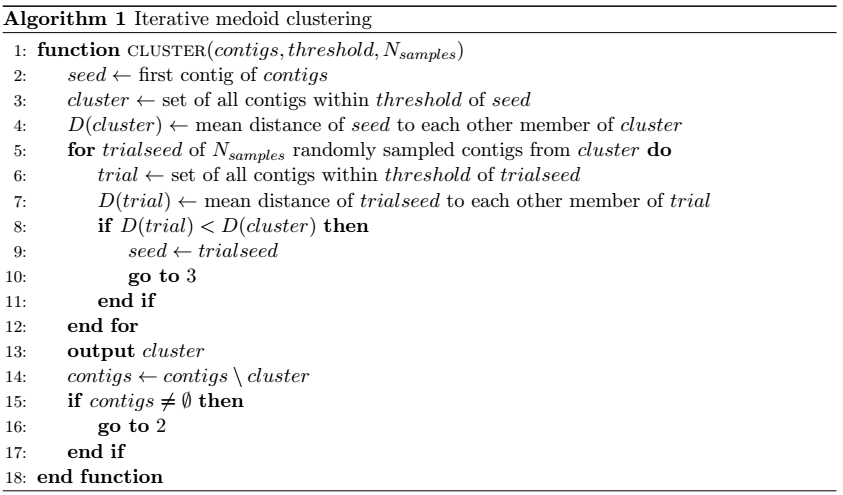

In [17]:
Image(filename='algorithm.png') 

__Determining clustering threshold__

You will notice that this algorithm depends on the parameter `threshold`. This corresponds to the threshold for Pearson distance, any contigs within which is considered part of the same bin. Getting this measure right is crucial for the binning to work well. Put it too low, and the bins will be highly fragmented. Too high, and distinct genomes will be binned together.

In order to estimate a good threshold for this distance, we have written the module `threshold`, in where you can find the function `getthreshold`:

---

In [14]:
help(vamb.threshold.getthreshold)

Help on function getthreshold in module vamb.threshold:

getthreshold(latent, distfunction, samples, maxsize)
    Estimate the clustering threshold from random sampling.
    
    Inputs:
        latent: An (n_contigs x n_latent) Numpy array
        distfunction: f such that f(latent, index) returns Numpy array with
                      distances to each corresponding contig in latent.
        samples: Number of random contigs to sample [1000]
        maxsize: Discard sample if more than N contigs are within estimated
                 sample threshold [2500]
        
    Output:
        median: Median of estimated clustering threshold
        support: Fraction of contigs with any estimated threshold
        separation: Fraction of contigs well separated



---
How does this work? If you pick a random contig and calculate the distance to all other contigs, the distributions will, roughly speaking follow one of the three distributions, plotted below in blue, orange and green:

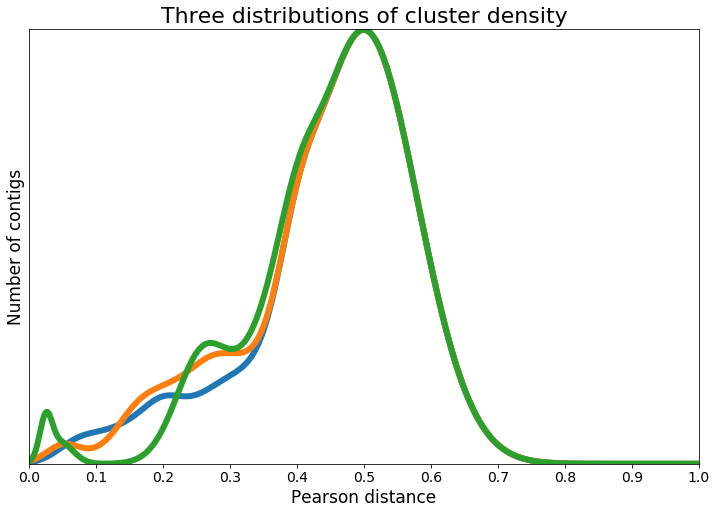

In [16]:
Image(filename='thresholdcurve.png') 

---
This curve is with faked data just for demonstration purposes - in reality, it's a *lot* more noisy.

Anyway, the basic idea here is that the distances relative to a randomly sampled contig sometimes separate neatly into a small group of close contigs and all the other contigs. The close contigs can then be assumed to be the within-bin and the far contigs the ones outside the bin.

When sampling, we typically see one of three patterns:

* The well-separating, here plotted in __green__. For these samples, the smaller peak of close contigs is clearly separated from the further contigs, and the optimal threshold distance is clearly somewhere in the range 0.1 - 0.15. Formally, we define the distances as well-separated as if the density falls to 0.025 or below between the two peaks. The threshold for this sample is then defined as the distance where the density falls to 0.025.

* The poorly-seperating samples, here plotted in __orange__. You can see a noticable dip in density at about distance = 0.1, so it appears there indeed is a group of close contigs and a group of far contigs, but the separation is less clear. These are the ones where the density falls to <= 80% of the peak density (in this plot, the valley at ~0.1 is < 0.8 * the peak at ~0.6). The threshold for poorly-separating samples is the point where the density falls below 80% of peak density.

* The non-separating samples, here in __blue__. The density at different distances is monotonically increasing, and we cannot find any suitable threshold for these contigs. Formally, we define these as where there are no valleys where the density fall below 80% of the peak value. No threshold is returned for these non-separating samples.

We then have defined two terms:

* The __support__ is the fraction of well-separating or poorly-separating samples.

* The __separation__ is the fraction of well-separating samples.

---
The `vamb.threshold.getthreshold` function samples a number of random contigs (2500 by default) and returns the median threshold, support and separation. Of course, if the support is too low, you can't really trust the threshold.

This function is kind of hand-wavey heuristic, but seem to work well in practice. This is one of the areas I'd like to see improved in the future. Anyway, let's give it a spin:

---

In [15]:
# We need to normalize the array first across axis 1
# otherwise the Pearson distance function will not work.
normalized = vamb.vambtools.zscore(latent, axis=1)

_ = vamb.threshold.getthreshold(normalized, distfunction=vamb.cluster._pearson_distances,
                                maxsize=2500, samples=2500)
threshold, support, separation = _

print('Estimated threshold:', round(threshold, 3))
print('Support:', round(support * 100, 1), '%')
print('Separation:', round(separation * 100, 1), '%')

Estimated threshold: 0.039
Support: 69.4 %
Separation: 6.5 %


The interface for determining the threshold may look a little awkward. The reason is that the next step, clustering using `vamb.cluster.cluster`, automatically determines the clustering threshold by calling the functions we've just manually done, unless explicitly passed a threshold parameter. Thus, manually callong the `getthreshold` function 
is only for more advanced usage (for example, quickly initializing multiple independent cluster iterators).

Anyway, now we can cluster. To do this, we need to use `vamb.cluster.cluster`:

---

In [16]:
help(vamb.cluster.cluster)

Help on function cluster in module vamb.cluster:

cluster(matrix, labels=None, threshold=None, maxsteps=25, destroy=False, normalized=False, nsamples=2500, maxsize=2500, logfile=None)
    Iterative medoid cluster generator. Yields (medoid), set(labels) pairs.
    
    Inputs:
        matrix: A (obs x features) Numpy matrix of data type numpy.float32
        labels: None or Numpy array with labels for matrix rows [None = indices]
        threshold: Optimal medoid search in this distance from medoid [None = auto]
        maxsteps: Stop searching for optimal medoid after N futile attempts [25]
        destroy: Destroy input matrix, saving memory. [False]
        normalized: Matrix is already zscore-normalized across axis 1 [False]
        nsamples: Estimate threshold from N samples [2500]
        maxsize: Discard sample if more than N contigs are within threshold [2500]
        logfile: Print threshold estimates and certainty to file [None]
    
    Output: Generator of (medoid, set(label

---
Depending on the size of the latent encoding, this can take some time. The heavy lifting here is done in Numpy, so it might be worth making sure the BLAS library your Numpy is using is fast. The difference between a fast and a slow Numpy implementation can be quite remarkable. You can check it with `numpy.__config__.show()` and if it says anything other than `NOT AVAILABLE` under the `mkl` or `openblas` entries, you're golden. 

The output of `vamb.cluster.cluster` is a generator, yielding `(medoid, cluster)` tuples. The generator will compute the clusters on-the-fly, meaning it will only compute the next cluster *once you ask for it*. Having the clustering return a generator gives a lot of flexibility:

You can manually iterate over the clusters:
    
    clusters = dict()
    for n, (medoid, cluster) in enumerate(vamb.cluster.cluster(latent)):
        clusters[medoid] = cluster
        
        if n + 1 == 1000: # Stop after 1000 clusters
            break
            
You can just put it directly in a dictionary:

    clusters = dict(vamb.cluster.cluster(latent))
    
Or you can use the `vamb.cluster.writeclusters` function to write the clusters to disk on the fly:

    cluster_iterator = vamb.cluster.cluster(latent)
    with open('clusters.tsv', 'w') as clusterfile:
        vamb.cluster.writeclusters(clusterfile, cluster_iterator)
        
In this example, we will load it into a dictionary immediately:

---

In [21]:
# Notice we mask the contignames, since the dataloader filtered some contigs away
cluster_iterator = vamb.cluster.cluster(latent, labels=np.array(contignames)[mask], threshold=threshold)
clusters = dict(cluster_iterator)

medoid, contigs = next(iter(clusters.items()))
print('First key:', medoid, '(of type:', type(medoid), ')')
print('Type of values:', type(contigs))
print('First element of value:', next(iter(contigs)), 'of type:', type(next(iter(contigs))))

First key: s30_NODE_968_length_16368_cov_5.42885 (of type: <class 'numpy.str_'> )
Type of values: <class 'set'>
First element of value: s30_NODE_2419_length_8239_cov_4.01278 of type: <class 'numpy.str_'>


---
__The arguments to `cluster.cluster`__

You shouldn't have to change any arguments other than `matrix` and `labels`, but for completeness, here's what they are:

You already know what `matrix` and `labels` does. If you pass `None` to `labels`, it will use the numbers 1 to `len(matrix)` as labels.

`threshold` correspond to $threshold$ in the algorithm above. If `None` is passed as `threshold`, the clustering functions automatically normalizes the input and runs `vamb.threshold.getthreshold`, then sets threshold to the median returned by `vamb.threshold.getthreshold`.

`max_steps` is the $N_{samples}$ in the algorithm. In short, it determines how long time the algorithm will search for the optimal medoid. It is not necessary to tweak this, just leave it to the default.

`destroy` is rather interesting. The clustering process iteratively removes rows from the input `matrix`, eventually destroying (i.e. rendering it a $0\times N_{latent}$ matrix). Because the user probably won't expect the input to the function to be mutated, the default behaviour is to copy the matrix and cluster the copy, leaving the original untouched. However, for large matrices, this extra RAM consumption might be unacceptable. Setting `destroy`=True suppresses this copying, saving memory.

If `normalized` is `True`, it will assume the input is already zscore-normalized across axis 1 and skip this. Else, it will normalize the array first. The Pearson distance calculation only works for normalized data, so if `normalized` is set to `True` and the input is in fact not normalized, results will definitely be bad.

`nsamples` and `maxsize` determines the behaviour of `getthreshold` if `threshold` is `None`. It controls the number of sampled contigs to get the median threshold for, and the maximum number of contigs within the estimated threshold.

If `logfile` is not `None` and `threshold` is `None`, the function will print the outputs of `vamb.threshold.getthreshold` to the logfile, and print a warning if the support and separation is too low. If `logfile` is `None` it will print to stderr only if the support and separation is too low.

---

<a id="postprocessing"></a>
## Postprocessing the clusters

We haven't written any dedicated postprocessing modules because how to postprocess really depends on what you're looking for in your data.

One of the greatest weaknesses of Vamb - probably of metagenomic binners in general - is that the bins tend to be highly fragmented. You'll have lots of tiny bins, some of which are legitimate (viruses, plasmids), but most are parts of larger genomes that didn't get binned properly - about 2/3 of the bins here, for example, are 1-contig bins.

We're in the process of developing a tool for annotating, cleaning and merging bins based on phylogenetic analysis of the genes in the bins. That would be extremely helpful, but for now, we'll have to use more crude approaches:

We throw away all bins with less than 250,000 basepairs.

---

In [26]:
lengthof = dict(zip(contignames, lengths))

# Now filter away the small bins
filtered_bins = dict()
for medoid, contigs in clusters.items():
    binsize = sum(lengthof[contig] for contig in contigs)
    
    if binsize >= 250000:
        filtered_bins[medoid] = contigs

print('Number of bins before filtering:', len(clusters))
print('Number of bins after filtering:', len(filtered_bins))

Number of bins before filtering: 1895
Number of bins after filtering: 136


---
That was almost 93% of the bins we filtered away! Now, let's save the clusters to disk. For this we will use two writer functions:

1) `vamb.cluster.writeclusters`, that writes which clusters contains which contigs to a simple tab-separated file, and

2) `vamb.vambtools.writebins`, that writes FASTA files corresponding to each of the bins to a directory. This might be useful for some types of analysis you want to do down the road.

We will need to load all the contigs belonging to any bin into memory to use `vamb.vambtools.writebins`. If the contigs in your bins don't fit in memory, sorry, you gotta find another way to make those FASTA bins.

The cluster name when printing either way will be the dictionary key of the bins. Right now, our bins have names like `gi|345651601|ref|NZ_JH114322.1|_[Bacteroides_dorei_5_1_36_D4_uid55593]_1189469-1207316` - not exactly poetic. We'll rename the bins first.

---

In [28]:
# Rename bin keys to something less horrible as a file name
filtered_bins = {'cluster_' + str(i+1): v for i, v in enumerate(filtered_bins.values())}

# This writes a .tsv file with the clusters and corresponding sequences
with open('/home/jakni/Downloads/example/clusters.tsv', 'w') as file:
    vamb.cluster.write_clusters(file, filtered_bins)

# Only keep contigs in any filtered bin in memory
keptcontigs = set.union(*filtered_bins.values())

with open('/home/jakni/Downloads/example/contigs.fna', 'rb') as file:
    fastadict = vamb.vambtools.loadfasta(file, keep=keptcontigs)
    
bindir = '/home/jakni/Downloads/example/bins'
vamb.vambtools.write_bins(bindir, filtered_bins, fastadict, maxbins=500)

<a id="summary"></a>
## Summary of full workflow

This is the full default workflow from beginning to end. Calling Vamb from command line does essentially this, except with some logging & deleting & saving intermediate results to files.

In [ ]:
import sys
import os
sys.path.append('/home/jakni/Documents/scripts/vamb')
import vamb

bamdir = '/home/jakni/Downloads/example/bamfiles/'
bampaths = [bamdir + filename for filename in os.listdir(bamdir) if filename.endswith('.bam')]

with open('/home/jakni/Downloads/example/contigs.fna', 'rb') as contigfile:
    tnfs, contignames, contiglengths = vamb.parsecontigs.read_contigs(contigfile)

rpkms = vamb.parsebam.read_bamfiles(bampaths)

vae = vamb.encode.VAE(nsamples=rpkms.shape[1])
dataloader, mask = vamb.encode.make_dataloader(rpkms, tnfs)
vae.trainmodel(dataloader)

latent = vae.encode(dataloader)

cluster_iterator = vamb.cluster.cluster(latent, labels=np.array(contignames)[mask])

with open('/home/jakni/Downloads/example/bins.tsv', 'w') as binfile:
    vamb.cluster.write_clusters(binfile, cluster_iterator)

<a id="memory"></a>
## Running VAMB with low memory (RAM)

In the VAMB software, a series of tradeoffs can be taken to decrease RAM consumption, usually to the detriment of some other property like speed or convenience. With all of those tradeoffs taken, VAMB is relatively memory efficient. By default, several of these tradeoffs are are not taken when running from a Python interpreter, however they are all enabled when running VAMB from command line.

The memory consumption of the encoding step is usually the bottleneck. With all memory-saving options enabled, this uses approximately $5*N_{contigs}*(136+N_{latent}+N_{samples})$ bytes, including overhead. As a rule of thumb, if you don't have at least three times that amount of memory, you might want to enable some or all of these memory optimizations.

Here's a short list of all the available memory saving options:

- When using `vamb.parsecontigs.read_contigs`, set the `preallocate` keyword to `True`. This doubles the time spent in the function, but significantly reduces RAM usage during this step.
- Pass a path to the `dumpdirectory` in the `vamb.parsecontigs.read_bamfiles` function. Temporary files will be written to files in this directory to avoid keeping them in memory. This takes a little bit of disk space, but saves lots of RAM
- In the `encode.make_dataloader` function, set `destroy` to True. This will in-place modify your RPKM and TNF array, deleting unusable rows and normalizing them. This prevents the creation of a copy of the data.
- Similarly, set `destroy=True` when using the `cluster.cluster` function. Again, the input (latent) datasets are modified in-place, saving a copy of the data. This function will completely consume the input array.
- When clustering, instead of generating clusters in memory, instantiate the cluster iterator and pass it directly to `cluster.write_clusters`. This way, each cluster will be written to disk after creation and not accumulate in memory. This obviously requires disk space, and you will have to reload the clusters if you are planning on using them.

<a id="benchmark"></a>
## Optional: Benchmarking your bins

If you want to tweak or enchance Vamb, you'll want to know how well it performs. For this to make any sense, you need to have a *reference*, that is, a list of bins that are deemed true and complete. Otherwise, what do you benchmark against?

Figuring out a proper way to benchmark binning tools is actually really hard because it requires taking a lot of subjective choices. When is a bin properly predicted? If we only accept perfectly binned bins, basically all binners have a 0 % accuracy. For any one bin we can calculate the fraction of the true genome present and the fraction of contaminating DNA - but if e.g. transposons are harder to bin but have no significant phenotypical effect, should they really count? And if a true bin is split across 25 % in four different observed bins, does that mean 25 % of the true genome is present in those bins, or is it in fact 0 %, because each of those bins will be predicted to be something different? If contigs are present in multiple bins, how do you prevent a bin from having more than 100 % presence? If your reference contains a broad selection of similar strains, surely it's not as bad to mix strains of the same species as to mix genomes from different phyla? And should you be benchmarked on the number of good bins you construct, or the fraction of good bins out of all the bins you make?

These choices have a significant impact on how you asses performance of your binner. For example, early on in the development of Vamb, we *did* allow the same contig present in multiple bins to both count towards completeness of bins. This led to a bias towards creating a huge number of overlapping bins until we changed the benchmarking.

Vamb's benchmarking works in the following way: You count the number of genomes for which *any* bin has a competeness (recall) above a certain level and a contamination below a certain level (precision above a certain level). Recall and precision is calculated by the number of basepairs covered in the right or wrong genome. In other words, for a bin B and a genome G, the recall is (# basepairs of G covered by a contig of B) / (# basepairs of G covered by any contig given to the binner), and precision is (# basepairs of G covered by a contig of B) / (# basepairs of any genome covered by a contig in B). An bin *can* count towards multiple genomes given a low enough precision threshold.

Let's go through how to benchmark your bins.

---

First, you need a proper reference. For each contig (or sequence) you are binning, you need to provide:
* The name of the contig
* The name of the genome the contig is coming from (genome names may be arbitrarily chosen)
* The name of the reference contig from that genome (may also be arbitrarily chosen)
* The leftmost position (start) of where the contig aligns to the reference contig
* The rightmost position (end) of where the contig aligns to the reference contig.

This information is given as a tab-separated file, with one line per contig. For example, suppose that I have a contig `test_contig_45` which I have located to belong to position 113501 to position 132884 in the reference contig `NC_013740.1` of the genome of `Acidaminococcus fermentans`. Then, one of the lines in the reference file will be:

    test_contig_45     Acidaminococcus fermentans       NC_013740.1    113501     132884

This file can then be loaded into a `Reference` object:
    
    with open('/path/to/ref_file.tsv') as ref_file:
        reference = Reference.from_file(ref_file)

Then you need to load your observed bins in. The format of this file is expected to be the same as the output of Vamb, namely a two-column file, with arbitrary bin names in the first column and contig names in the second column. Any contig seen in the observed bins is expected to be present in the reference as well. You also need to provide the reference:

    with open('/path/to/clusters.tsv') as clusters_file:
        bins = Binning.from_file(clusters_file, reference)
        
You can the query the bins for information about the quality of your bins. Below I'll show an example of this in practice: I will use Vamb's performance on the `metabat_errorfree` dataset and compare it to that of METABAT2.

In [3]:
# First load in the Reference
reference_path = '/home/jakni/Downloads/benchmark/reference.tsv'

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    reference = vamb.benchmark.Reference.from_file(reference_file)

gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_1-5871	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	1	5871
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_5841-8340	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	5841	8340
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_8310-10809	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	8310	10809
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_10779-29944	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	10779	29944
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_29914-33073	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	29914	33073
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_33043-41174	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	33043	41174
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococcus_D21_uid55871]_41144-44994	Acidaminococcus_D21_uid55871	NZ_ACGB01000001.1	41144	44994
gi|224815735|ref|NZ_ACGB01000001.1|_[Acidaminococc

---
The first 10 lines wrap, but you can see the information expected to be present.

The `reference` object contains a bunch of attributes which keeps track of which contigs belongs to which bins. You can see which ones using good ol' `help`:

`>>> help(reference)`

    Help on Reference in module vamb.benchmark object:

    class Reference(builtins.object)
     |  A set of Genomes known to represent the ground truth for binning.
     |  >>> print(my_genomes)
     |  [Genome('E. coli'), ncontigs=95, breadth=5012521),
     |   Genome('Y. pestis'), ncontigs=5, breadth=46588721)]
     |  >>> Reference(my_genomes)
     |  Reference(ngenomes=2, ncontigs=100)
     |  
     |  Properties:
     |  self.genome: {genome_name: genome} dict
     |  self.contigs: {contig_name: contig} dict
     |  self.genomeof: {contig_name: genome} dict
     |  self.ngenomes
     |  self.ncontigs
     |  
     |  Methods defined here:

    [ ... ]
    
Now the bins:

---

In [4]:
with open('/home/jakni/Downloads/benchmark/vamb_clusters.tsv') as clusters_file:
    vamb_bins = vamb.benchmark.Binning.from_file(clusters_file, reference)
    
with open('/home/jakni/Downloads/benchmark/metabat_clusters.tsv') as clusters_file:
    metabat_bins = vamb.benchmark.Binning.from_file(clusters_file, reference)

---
The Binning object keeps track of your bins and how they relate to the `Reference`:

    help(vamb_bins)
    
        class Binning(builtins.object)
     |  The result of an Binning applied to a Reference.
     |  >>> ref
     |  (Reference(ngenomes=2, ncontigs=5)
     |  >>> b = Binning({'bin1': {contig1, contig2}, 'bin2': {contig3, contig4}}, ref)
     |  Binning(4/5 contigs, ReferenceID=0x7fe908180be0)
     |  >>> b[(0.5, 0.9)] # num. genomes 0.5 recall, 0.9 precision
     |  1
     |  
     |  Properties:
     |  self.reference:       Reference object of this benchmark
     |  self.recalls:         Sorted tuple of recall thresholds
     |  self.precisions:      Sorted tuple of precision thresholds
     |  self.nbins:           Number of bins
     |  self.ncontigs:        Number of binned contigs
     |  self.contigsof:       {bin_name: {contig set}}
     |  self.binof:           {contig: bin_name}
     |  self.breadthof:       {bin_name: breadth}
     |  self.intersectionsof: {genome: {bin:_name: intersection}}
     |  self.breadth:         Total breadth of all bins
     |  self.mean_f1:         Mean F1 score among all Genomes
     |  self.mean_mcc         Mean Matthew's correlation coef. among all Genomes
     |  
     |  Methods defined here:
     
     [ ... ]

---
The easiest way to get information about the quality of a `Binning` is by using the `print_matrix` method:

---

In [5]:
print('Vamb bins:')
vamb_bins.print_matrix()
print('\nMETABAT2 bins:')
metabat_bins.print_matrix()

Vamb bins:
	Recall
Prec.	0.3	0.4	0.5	0.6	0.7	0.8	0.9	0.95	0.99
0.3	215	212	207	194	163	104	38	11	0
0.4	183	180	176	166	141	93	31	9	0
0.5	148	145	142	133	115	77	27	8	0
0.6	129	127	125	117	100	65	23	7	0
0.7	128	126	124	116	100	65	23	7	0
0.8	123	122	121	113	99	64	23	7	0
0.9	118	117	116	108	96	63	22	7	0
0.95	110	109	108	103	91	59	20	6	0
0.99	81	80	79	77	68	49	18	5	0

METABAT2 bins:
	Recall
Prec.	0.3	0.4	0.5	0.6	0.7	0.8	0.9	0.95	0.99
0.3	176	160	141	123	93	42	7	1	0
0.4	155	142	128	113	85	35	5	1	0
0.5	138	125	113	100	74	30	4	1	0
0.6	127	115	104	91	68	28	4	1	0
0.7	122	110	101	89	66	28	4	1	0
0.8	118	106	98	86	63	28	4	1	0
0.9	103	94	88	80	59	26	3	0	0
0.95	93	87	82	76	57	25	3	0	0
0.99	64	59	57	53	42	21	3	0	0


---
On the [metabat webpage](https://bitbucket.org/berkeleylab/metabat/wiki/CAMI) they have a neat plot where they plot the number of observed bins at different recalls for a specific specificity. Just for fun, let's recreate that here with the metabat_errorfree data.

---

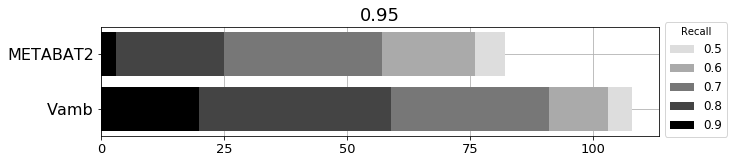

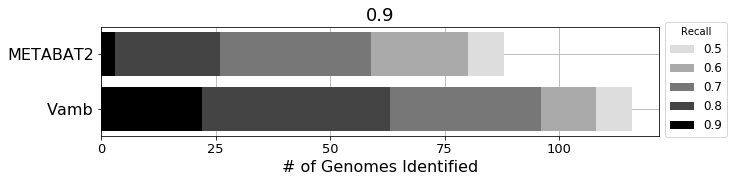

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

for precision in 0.95, 0.9:
    plt.figure(figsize=(10, 2))
    colors = ['#DDDDDD', '#AAAAAA', '#777777', '#444444', '#000000']
    recalls = [0.5, 0.6, 0.7, 0.8, 0.9]
    for y, bins in zip((0, 1), (vamb_bins, metabat_bins)):
        for color, recall in zip(colors, recalls):
            plt.barh(y, bins[recall, precision], color=color)

    plt.title(str(precision), fontsize=18)
    plt.yticks([0, 1], ['Vamb', 'METABAT2'], fontsize=16)
    plt.xticks([i*25 for i in range(5)], fontsize=13)
    plt.legend([str(i) for i in recalls], bbox_to_anchor=(1, 1.1), title='Recall', fontsize=12)
    
    if precision == 0.9:
        plt.xlabel('# of Genomes Identified', fontsize=16)
    plt.gca().set_axisbelow(True)
    plt.grid()

<a id="improvements"></a>
## Potential improvements to Vamb

Vamb is under an MIT licence, so please feel free to fork, extend, or copy Vamb however you see fit. If you do, feel free to write us an email.

Here's a short wish list for improvements to Vamb we haven't had time for:

__Add more training datasets and do a more throrough hyperparameter search__

This is probably the easiest (if time consuming) way to improve Vamb, and possibly may have the biggest impact. The problem is that clusters are not independent of the dataset they're in - what works for one dataset might not work for another. So get a collection of datasets, like the toy datasets from CAMI2, e.g. 5-10 training datasets and test more hyperparameters. In parcitular, these hyperparameters might be interesting to look at:

$\alpha$

This controls the relationship between CE and SSE, which has turned out to be critically important and unfortunately highly sensitive in our testing. But what controls the optimal value of $\alpha$? Number of samples? Sparsity of the abundance matrix? Length of contigs? Failing to answer this, even just getting the optimal $\alpha$ for more different datasets would be nice.

$\beta$

This controls the relationship between KLD and the reconstruction loss. I think it's unrealistic to expect to find an explanation for why this needs to be as it is, but optimizing it across more datasets would certainly help.

*Sinusoidal increase of batchsize*

When batchsize increases during training, we see an abrupt drop in loss. I suspect that this immediate drop has very little to do with the intention of increasing batchsize (finding more "flat" minima, e.g. robust minima, as well as simply decreasing stochastic movement similarly to simulated annealing). Rather, it seems that when changing the batch size, the network suddenly find that its local minima is no longer a minima, and jerks in a more favorable direction. Interestingly, this is *not* accompanied by an initial increase in loss, so it's an all-round win. In fact, in our tests, it seems to be an amazingly effective way to kick your network out of a local minima.

Cyclical changes in learning rate have been used widely in the literature. Perhaps we can alter batch size cyclically, such that it varies between e.g. 64 and 4096 (with more epochs at the larger batch sizes), perhaps with the minimal batch size increasing over time. It could also be interesting to look at what with a cyclical batch size with single epochs of very low batch sizes, like 32 or 16 - does this give even bigger kicks to the network, allowing it to explore even lower minima?

*The relationship between number of epochs, $\beta$ and batchsize*

The best number of epochs might not be exactly 500 - but this number surely depends on a lot of other factors. It's probably best to explore the other hyperparameters with a fixed number of epochs (say 500, or even 1000), then later optimize number of epochs.

__Better exploitation of TNF information in clustering__

There's quite a lot of information in the TNF of contigs, and Vamb is fairly bad at exploiting it. 

The expected TNF distance between two contigs follows approximately a chi distribution (exercise left for reader: assuming all tetranucleotides have an independent probability of being observed, show that you can model the *euclidian* TNF distance using a chi square distribution). More importantly, in *practice*, it follows a chi square distibution. Similarly, the empirical probability of two contigs belonging to different species as a function of the TNF is well modeled by the cumulative density function of a chi distribution.

However, the exact shape of the chi distribution depends on the phylogenetic distance between the genomes of the contigs, and also the the lengths of the two contigs. Hence, a clustering algorithm which simply looks at the raw TNF value without taking in to account contig lengths is not as effective as it could be.

When experimenting with Vamb, we checked if we could, when presented with random pairs of contigs, heurisitcally estimate the parameters of the estimated chi distribution of TNF distances between contigs of those lengths and based on that distribution predict whether or not the two contigs belonged in the same bin. It was quite accurate, but instantiating a `scipy.stats.chi` object with the right parameters for each contig pair would make our clustering algorithm take weeks or months to run for a one-million-contig dataset.

A possible future approach could be to encode the depths and TNF independently with the VAE (although it could still train using both depths and TNF at the same time), and, when calculating the contig-contig distances during clustering, using a heuristic approximation of the chi distribution which can be computed quickly. Alternatively, one could cluster exclusively on depths, then afterwards identify contigs in bins with divergent TNF and/or recruit unbinned contigs to bins with similar TNF.

__Determine clustering threshold for each cluster__

This shouldn't be too hard to do, but at the moment I thought about it, we were too close to publication to mess everything up by changing the algorithm.

The idea is that normally, VAMB estimates the clustering threshold by sampling some random contigs and looking for the threshold which separates a small group of close contigs from the rest. I have written the threshold estimation completely ad hoc. I suspect it's possible to create a more robust and accurate threshold detection method if one thinks some more about it. During clustering, the threshold can then be determined to be optimal for each seed cluster.

More interestingly, it could even refuse to produce clusters for which no threshold can be determined (as this indicates it's not separated). When all the cluster-able clusters have been removed, it could resume training or otherwise change the encoding, then cluster the remaining clusters.

In some very quick-and-dirty preliminary tests, I estimate that it would slow down clustering by 4x, but perhaps a more elegant and quicker solution to threshold estimation can be invented.

__Switch to a more theoretically founded distance measure__

We chose Pearson correlation because Canopy chose it, and because it intuitively made sense. In order to support the choice, we calculated the separation between the distance distributions for within and between-species for a variety of distance measures, including Pearson, Spearman, 1-norm, 2-norm, Jaccard and cosine. Before encoding, 1-norm did slightly better than the others - after encoding, Pearson was the best, but only by a bit.

I have no idea of how the data *ought* to be distributed in the encoded space, so let's reason about the input space (abundance, in particular), and assume that whatever distance measure works for input space also works for latent space. Why would Pearson be the right choice?

Well, really, it wouldn't. For example, the two following depth vectors:
   
    [50 50 51 51]
    [50 51 50 51]
    
Has a Pearson correlation of exactly 0, although the depths are clearly almost 100% correlated in the relevant sense of the word. The problem here is that Pearson is translation invariant, whereas we really want a measure which is *not* translation invariant (i.e. which measures how close to a fixed ratio there is between the two vectors). 

I don't know what the best measure here is. I don't think the Aitchison distance measure is right to use.

__Use PyTorch to implement GPU-based clustering__

Clustering right now is implemented in Numpy. The speed bottleneck is the calculation of Pearson distances from one contig to the others, and this is dominated by a single multiplication of a matrix with a vector. While fast when implemented in Numpy with a proper BLAS library underneath, GPUs excel at operations on large, dense matrices. Using PyTorch, it should be possible to implement a device-agnostic clustering, enabling GPU acceleration. In the `src` directory, there is my attempt at doing it, but on our datasets, it yielded no speed improvements. There must be some speed bottlenecks that could be optimized away, but I didn't want to spend days doing that.

__Switch to a true distance measure for tandem clustering__

So our clustering scales quadratically. That's alright for normally sized datasets, but at some point, someone is going to want to cluster 5000 samples. How can we circumvent this?

Well, if we look at Canopy clustering (not to be confused with the binning method referred to as Canopy), that prevents the issue by creating intersecting (i.e. non-disjoint) sets of contigs which I call partitions, and then clustering those partitions independently. In an earlier version of VAMB, I implemented this and called it `tandemclustering`. However, because I couldn't solve the following problem, I ended up deleting that code.

The problem is this: When splitting the dataset, it's highly likely that the contigs of a true bin will end up in different partitions. If that happens, it's impossible for the bin to be reconstructed. And we can't easily partition in a manner which preserves the bins' integrity, because that would require us to know the bins beforehand which is the entire point of clustering!

We can solve it with the following splitting function:

    function split(set contigset, float INNER, float OUTER):
        while there are more than 20,000 contigs in contigset:
            S = random contig from contigset
            partition = All contigs in contigset within OUTER distance of S
            yield partition
            superfluous = All contigs in contigset within INNER distance of S
            delete superfluous from contigset
            
        yield contigset # last partition with at most 20,000 elements
        
We can prove this works:

    For any bin B, for any partition seed S, let C be the contig in B closest to S
    Let F be the contig in B furthest from S
    If |SC| > INNER, all contigs in B remains in contigset and the bin is not split (1)
    If |SF| ≤ OUTER, all contigs in B is contained in the partition, bin is not split (2)
    Let us assume we have picked values of INNER and OUTER such that OUTER-INNER > |CF| (cond. A)

    If |SC| > INNER:
        Bin B is not split since (1)

    Else it must be the case that:
        |SC| ≤ INNER, which can be rearranged by (A) to
        |SC| ≤ OUTER - |CF|, adding |CF| gives
        |SC| + |CF| ≤ OUTER, and by the tringle inequality |SF| ≤ |SC| + |CF|:
        |SF| ≤ OUTER, which, by (2) means bin B is not split
            
Hence we just need to pick values for `INNER` and `OUTER` to follow condition A, which means that the difference between `INNER` and `OUTER` should be above the cluster diameter for most realistic bins. No problem.

Unfortunately, this relies on the triangle inequality `|SF| ≤ |SC| + |CF|` which does not hold true for Pearson distance and Spearman distance, and so bins will likely get split when partitioning, giving lower recalls. This implies that tandem clustering will perform better with other distance measures like 1-norm or 2-norm distance. Of course, we can't just use 1-norm distance when partitioning and then use Pearson when clustering!

While it would be trivial to change the distance measure used in `clustering.py`, it is difficult to map e.g. 1-norm distances to a fixed interval [0, 1], and so we have not found a way to approximate the clustering threshold needed. Also, preliminary tests we did have shown that Pearson distance separates the latent representation slightly better than 1- or 2-norm distance (although the loss of accurary by poor partitioning might offset this).